In [1]:
import torch as th
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from import_dataset import load_cifar10_data
from model import UNetLite

In [2]:
trainset, testset = load_cifar10_data(normalize=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
mask_idx = 5
result_idx = 36
masks_path = Path(f"../data/masks/mask_{mask_idx}.pt")
if not masks_path.exists():
    raise FileNotFoundError(f"Mask file {masks_path} does not exist. Please generate it first.")
masks = th.load(masks_path)
len(masks)

weights_path = Path(f"../data/weights/weights_{result_idx}.pt")
if not weights_path.exists():
    raise FileNotFoundError(f"Weights file {weights_path} does not exist.")
weights = th.load(weights_path, map_location=th.device("cpu"))

In [4]:
model = UNetLite()
model.load_state_dict(weights)

<All keys matched successfully>

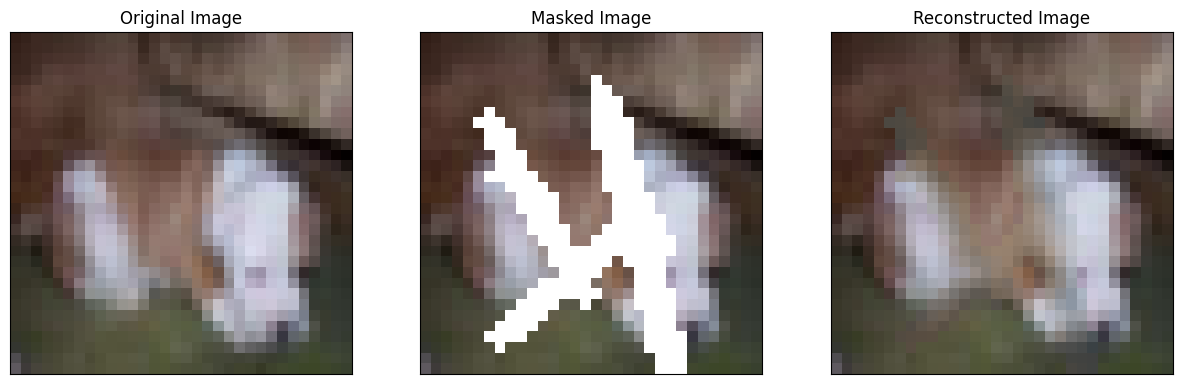

In [5]:
random_idx = np.random.randint(0, len(testset))
random_mask_idx = np.random.randint(0, len(masks))

sample_img = testset[random_idx][0].unsqueeze(0)  # Add batch dimension
sample_mask = masks[random_mask_idx].unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)  # Add batch dimension
with th.no_grad():
    model.eval()
    output = model(sample_img * sample_mask, sample_mask.float())
sample_img = sample_img * 0.5 + 0.5  # Rescale to [0, 1] range
reconstructed_img = th.where(sample_mask, sample_img, output)

masked_image = th.where(sample_mask, sample_img, th.ones_like(sample_img) * th.nan)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

vmin = min(sample_img.min(), output.min())
vmax = max(sample_img.max(), output.max())

axs[0].imshow(sample_img.squeeze().permute(1, 2, 0).numpy(), vmin=vmin, vmax=vmax)
axs[0].set_title("Original Image")
axs[1].imshow(masked_image.squeeze().permute(1, 2, 0).numpy(), vmin=vmin, vmax=vmax)
axs[1].set_title("Masked Image")
axs[2].imshow(reconstructed_img.squeeze().permute(1, 2, 0).detach().numpy(), vmin=vmin, vmax=vmax)
axs[2].set_title("Reconstructed Image")

for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])